Updated property [core/project].


已設定專案為: fakenewsbda
3.12.3: Pulling from library/python
Digest: sha256:3966b81808d864099f802080d897cef36c01550472ab3955fdd716d1c665acd6
Status: Image is up to date for python:3.12.3
docker.io/library/python:3.12.3
Docker 鏡像拉取成功。
28b8597f0214593899287defddf92ca8a52be1fc042a039679f4db0cfda3952e
Docker 容器已部署並運行。


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/16 17:06:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Building prefix dict from the default dictionary ...                (0 + 4) / 4]
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 2.122 seconds.
Prefix dict has been built successfully.
Loading model cost 2.084 seconds.
Prefix dict has been built successfully.
Loading model cost 2.420 seconds.
Prefix dict has been built successfully.
Loading model cost 2.288 seconds.
Prefix dict has been built successfully.
25/01/16 17:07:37 W

LDA 主題分析結果：
主題 0: 運動(0.016), 輻射(0.0137), 輻射劑(0.0105), 魚群(0.01), 大麻(0.0094), 暴斃(0.0086), 量(0.008), 腳(0.0073), 毒品(0.0072), 硝酸(0.0063)
主題 1: 投票(0.0191), 男子(0.008), 北約(0.0077), 保安(0.0055), 爆炸(0.0054), 堂(0.0049), 廣告(0.0048), 法國(0.0047), 女子(0.0047), 歐洲(0.0042)
主題 2: 麵(0.0129), 印度(0.0119), 感染(0.0104), 茶(0.0094), 遊行(0.0082), 皮膚(0.007), 奶茶(0.0066), 飲料(0.0063), 食品(0.0059), 添加(0.0059)
主題 3: 地瓜(0.0181), 葡萄(0.0141), 蔬菜(0.0139), 癌症(0.0122), 蜂蜜(0.0122), 細胞(0.01), 固醇(0.0088), 斑部(0.0078), 瑞士(0.007), 抗氧化(0.0064)
主題 4: 旅客(0.0104), 快艇(0.0089), 海巡(0.0086), 翻覆(0.0082), 乘客(0.0078), 光線(0.0075), 高鐵(0.0075), 船(0.0073), 斑部(0.0066), 疫苗(0.0066)
主題 5: 匭(0.0084), 日本(0.0081), 治療(0.0067), 瑞德(0.006), 紙箱(0.0052), 糖尿病(0.0051), 韓國(0.005), 籽(0.005), 投票(0.005), 施工(0.0049)
主題 6: 烏克蘭(0.0139), 俄羅斯(0.0088), 拜登(0.007), 以色列(0.0061), 美國(0.006), 軍事(0.0055), 盃(0.0051), 總統(0.005), 立陶宛(0.0044), 解放(0.0043)
主題 7: 芒果(0.0267), 農藥(0.0154), 加州(0.0101), 生長(0.0097), 基因(0.0081), 蛋白(0.0076), 過敏(0.0069), 疫苗(0.0067), 上市(0.006), 性別(0.0058)
主題 8: 雞

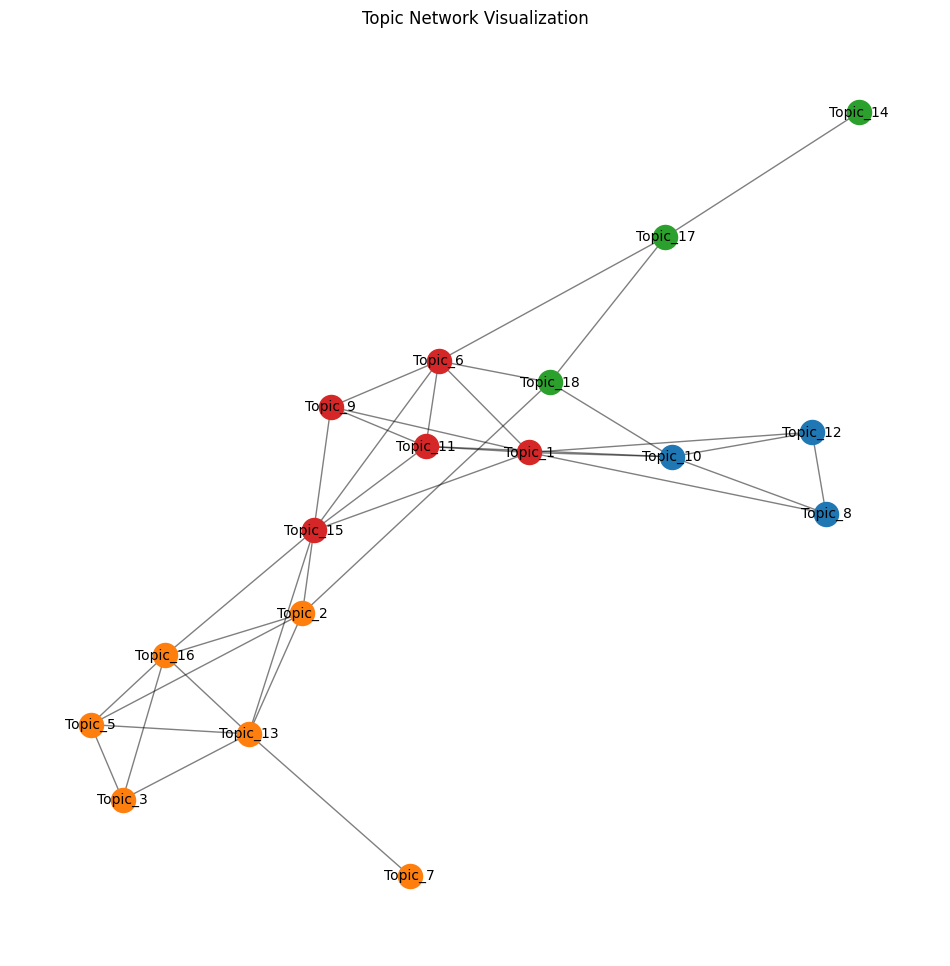

In [1]:
import os
import subprocess
import sys
import jieba
import re
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from community import community_louvain
import matplotlib.colors as mcolors
import random
import math

# 初始化 SparkSession
def initialize_spark():
    """初始化 SparkSession"""
    return SparkSession.builder.appName("PySpark LDA Analysis with Simulated Annealing").getOrCreate()

# 從文件中讀取停用詞
def load_stopwords(filepath):
    """從文件中讀取停用詞"""
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            return set(line.strip() for line in file)
    except FileNotFoundError:
        print(f"停用詞文件 {filepath} 未找到，請確認路徑是否正確。")
        sys.exit(1)

# 文本處理與分詞
def process_text(text, stopwords):
    """文本處理與分詞"""
    if text is None:
        return []
    words = jieba.cut(re.sub(r"[^\u4e00-\u9fa5]", "", text))
    return [word for word in words if word not in stopwords]

# 模擬退火算法選擇最佳主題數量
def simulated_annealing_lda(tfidf_data, max_iter=10):
    """使用模擬退火算法選擇最佳主題數量"""
    def calculate_perplexity(k):
        lda = LDA(k=k, maxIter=max_iter, featuresCol="tfidf_features")
        model = lda.fit(tfidf_data)
        return model.logPerplexity(tfidf_data)

    # 初始化模擬退火參數
    current_k = random.randint(2, 20)  # 初始主題數量
    current_perplexity = calculate_perplexity(current_k)
    best_k = current_k
    best_perplexity = current_perplexity
    T = 100  # 初始溫度
    alpha = 0.95  # 降溫係數

    while T > 1:
        # 隨機選擇新的主題數量
        new_k = max(2, min(20, current_k + random.choice([-1, 1])))
        new_perplexity = calculate_perplexity(new_k)

        # 接受概率計算
        delta = new_perplexity - current_perplexity
        acceptance_probability = math.exp(-delta / T) if delta > 0 else 1

        if random.random() < acceptance_probability:
            current_k = new_k
            current_perplexity = new_perplexity

        # 更新最佳解
        if current_perplexity < best_perplexity:
            best_k = current_k
            best_perplexity = current_perplexity

        T *= alpha  # 降溫

    return best_k

# 執行 LDA 分析
def lda_analysis(spark, csv_path, stopwords_path):
    """執行 LDA 分析"""
    stopwords = load_stopwords(stopwords_path)
    process_text_udf = udf(lambda text: process_text(text, stopwords), ArrayType(StringType()))

    # 加載數據
    data = spark.read.csv(csv_path, header=True, inferSchema=True)
    data = data.select('title', 'body').dropna()

    # 分詞與向量化
    data = data.withColumn("filtered_words", process_text_udf(data["body"]))
    vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features", vocabSize=5000, minDF=5)
    vectorized_model = vectorizer.fit(data)
    vectorized_data = vectorized_model.transform(data)

    # 計算 TF-IDF
    idf = IDF(inputCol="features", outputCol="tfidf_features")
    idf_model = idf.fit(vectorized_data)
    tfidf_data = idf_model.transform(vectorized_data)

    # 使用模擬退火算法選擇最佳主題數量
    optimal_k = simulated_annealing_lda(tfidf_data)
    lda = LDA(k=optimal_k, maxIter=10, featuresCol="tfidf_features")
    lda_model = lda.fit(tfidf_data)

    # 打印主題結果
    topics = lda_model.describeTopics(10).toPandas()
    vocab_list = vectorized_model.vocabulary
    topics["terms"] = topics["termIndices"].apply(lambda indices: [vocab_list[idx] for idx in indices])
    topics["weights"] = topics["termWeights"].apply(lambda weights: [round(w, 4) for w in weights])

    print("LDA 主題分析結果：")
    for i, row in topics.iterrows():
        keywords_with_weights = ", ".join(
            [f"{term}({weight})" for term, weight in zip(row["terms"], row["weights"])]
        )
        print(f"主題 {i}: {keywords_with_weights}")

    doc_topics = lda_model.transform(tfidf_data)
    doc_topics_pd = doc_topics.select("title", "topicDistribution").toPandas()
    doc_topics_pd["topicDistribution"] = doc_topics_pd["topicDistribution"].apply(
        lambda x: np.array(x, dtype=np.float64)
    )

    return lda_model, doc_topics_pd

# 可視化主題網絡
def visualize_topics(doc_topics_pd):
    """可視化主題網絡"""
    doc_topic_matrix = np.array(doc_topics_pd["topicDistribution"].tolist())
    cosine_sim = cosine_similarity(doc_topic_matrix.T)
    G = nx.Graph()

    # 建立網絡圖
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            if cosine_sim[i, j] > 0.1:
                G.add_edge(f"Topic_{i}", f"Topic_{j}", weight=cosine_sim[i, j])

    # 社區檢測
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')

    # 視覺化網絡圖
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 12))
    communities = nx.get_node_attributes(G, 'community')
    unique_communities = set(communities.values())
    color_map = list(mcolors.TABLEAU_COLORS.values())

    for community in unique_communities:
        nodes = [node for node in G.nodes if communities[node] == community]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_size=300,
                               node_color=color_map[community % len(color_map)])

    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title("Topic Network Visualization")
    plt.axis('off')
    plt.show()

# 部署 Docker 容器
def deploy_docker_container(instance_name, zone, docker_image):
    """部署 Docker 容器"""
    try:
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", f"sudo docker pull {docker_image}"
        ], check=True)
        print("Docker 鏡像拉取成功。")

        deploy_command = f"sudo docker run -d {docker_image}"
        subprocess.run([
            "gcloud", "compute", "ssh", instance_name,
            "--zone", zone,
            "--command", deploy_command
        ], check=True)
        print("Docker 容器已部署並運行。")
    except subprocess.CalledProcessError as e:
        print(f"部署 Docker 容器失敗: {e}")
        sys.exit(1)

# 主程序入口
def main():
    """主程序"""
    project_id = "fakenewsbda"
    instance_name = "lda-analysis-instance"
    zone = "us-central1-a"
    machine_type = "e2-standard-4"
    image_project = "debian-cloud"
    image_family = "debian-11"
    docker_image = "python:3.12.3"

    # 初始化 GCP 環境
    try:
        subprocess.run(["gcloud", "config", "set", "project", project_id], check=True)
        print(f"已設定專案為: {project_id}")
    except subprocess.CalledProcessError as e:
        print(f"設定 GCP 專案失敗: {e}")
        sys.exit(1)

    # 部署 Docker
    deploy_docker_container(instance_name, zone, docker_image)

    # 啟動 Spark 和執行分析
    spark = initialize_spark()
    csv_path = "/home/rrrrryeedie/final_sorted_output.csv"
    stopwords_path = "/home/rrrrryeedie/stopwords.txt"
    lda_model, doc_topics_pd = lda_analysis(spark, csv_path, stopwords_path)
    visualize_topics(doc_topics_pd)

if __name__ == "__main__":
    main()
